In [7]:
#!pip install segmentation_models_pytorch albumentations
#import torch
#import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

In [8]:
#Mount Google Drive with dataset
from google.colab import drive
drive.mount('/content/drive/')
sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks/code/')
import hist_consistency

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
#Define device, path to model weights and initialize FPN-model
device = 'cuda'
modelpath = '/content/drive/MyDrive/best_model_FPN_efficientnet-b4_ep100_bs11_wc_wlrsch_lr0_001_imagenet.pth'
model = smp.FPN(encoder_name='efficientnet-b4', activation='sigmoid', encoder_weights=None, encoder_depth=5, in_channels=1)
model.load_state_dict(torch.load(modelpath))
model.to(device)

In [9]:
#Define path to ground-truth masks
sourcepath = '/content/drive/MyDrive/train_images_512x512_npy/masks'
#Collect pathes of ground-truth masks and raw images in two lists
mask_names = [os.path.join(sourcepath, i) for i in os.listdir(sourcepath)]
predict_mask_names = [i.replace('train_images_512x512_npy/masks', 'masks_FPN_predict') for i in mask_names]
#img_names = [i.replace('masks', 'images') for i in mask_names]

In [22]:
coarse_thresholds = [i / 10. for i in range(10, -1, -1)]
consistencies = dict()

In [23]:
#Predict masks of 3000 raw images of size 512x512, postprocess them using watershed algorithm with fixed parameter
#Measure pore areas values of ground-truth and predicted masks
#Compare results by intersection values (Jaccard coefficient, or IoU value) of corresponding histograms
#Maximum average IoU value is optimum
N = 500
for coarse_threshold in coarse_thresholds:
    fine_thresholds = [i / 10. for i in range(int(coarse_threshold * 10), -1, -1)]
    for fine_threshold in fine_thresholds:
        consistency = 0
        skip = 0
        for i in range(N):
            if i in [N // 3, (N // 3) * 2, N - 1]:
                print('#', end='')
            mask1 = np.load(mask_names[i])
            mask2 = np.load(predict_mask_names[i])
            #img = np.load(img_names[i])
            #img = np.expand_dims(img, axis=0).astype('float32')
            #img = torch.from_numpy(img).to(device).unsqueeze(0)
            #mask2 = model.predict(img)
            #mask2 = mask2.squeeze().cpu().detach().numpy().round().astype('uint8')
            mask2 = hist_consistency.postproc3(mask2, coarse_threshold=coarse_threshold, fine_threshold=fine_threshold)
            area1 = hist_consistency.area(mask1)
            area2 = hist_consistency.area(mask2)
            area1 = area1[area1 > 50]
            area2 = area2[area2 > 50]
            if area1.shape[0] == 0 or area2.shape[0] == 0:
                skip += 1
                continue
            consistency += hist_consistency.intersection(area1, area2, bin_width=100, plot_hist=False)
        consistencies[(coarse_threshold, fine_threshold)] = consistency / (N - skip)
        print(' ', (coarse_threshold, fine_threshold), consistencies[(coarse_threshold, fine_threshold)], skip)

###  (1.0, 1.0) 0.4366809338245327 28
###  (1.0, 0.9) 0.4001721586103974 28
###  (1.0, 0.8) 0.4252516762554962 28
###  (1.0, 0.7) 0.44803671176302645 28
###  (1.0, 0.6) 0.45795408197824805 28
###  (1.0, 0.5) 0.4633445752306783 28
###  (1.0, 0.4) 0.4700738759072054 28
###  (1.0, 0.3) 0.4661899005026674 28
###  (1.0, 0.2) 0.4681711825135015 28
###  (1.0, 0.1) 0.46433887191910717 28
###  (1.0, 0.0) 0.4366809338245327 28
###  (0.9, 0.9) 0.44712056579498294 28
###  (0.9, 0.8) 0.4534130370127486 28
###  (0.9, 0.7) 0.4621633576440621 28
###  (0.9, 0.6) 0.46837457569057556 28
###  (0.9, 0.5) 0.4719009716764767 28
###  (0.9, 0.4) 0.4759393472091185 28
###  (0.9, 0.3) 0.4718574151504674 28
###  (0.9, 0.2) 0.4711981707031347 28
###  (0.9, 0.1) 0.4685579559816661 28
###  (0.9, 0.0) 0.4366809338245327 28
###  (0.8, 0.8) 0.4543528386848805 28
###  (0.8, 0.7) 0.4626472016735813 28
###  (0.8, 0.6) 0.46784642857518877 28
###  (0.8, 0.5) 0.4723434316334405 28
###  (0.8, 0.4) 0.47636061300466387 28
###  

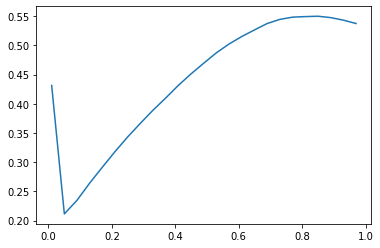

In [ ]:
#Plot dependence of IoU value from parameter of watershed algorithm
plt.plot(sure_fg_thresholds, consistencies)

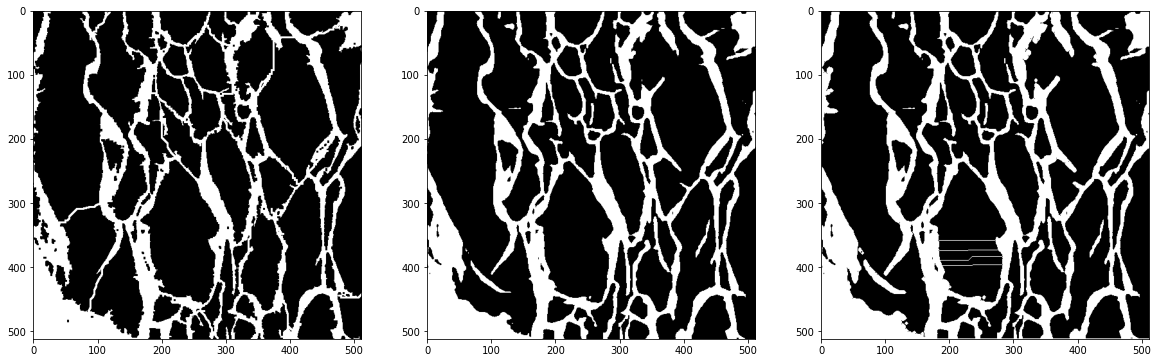

<Figure size 1440x1440 with 0 Axes>

In [ ]:
#Look at ground-truth, predicted and postprocessed masks
i = 205
sure_fg_threshold = 0.85
img = np.load(img_names[i])
img = np.expand_dims(img, axis=0).astype('float32')
img = torch.from_numpy(img).to(device).unsqueeze(0)
mask = np.load(mask_names[i])
pred = model.predict(img)
pred = pred.squeeze().cpu().numpy().round().astype('uint8')
pred_postproc = hist_consistency.postproc(pred, sure_fg_threshold=sure_fg_threshold)
pred_postproc = hist_consistency.postproc(pred_postproc, sure_fg_threshold=sure_fg_threshold)
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
fig = plt.figure(figsize=(20, 20))
ax[0].imshow(mask, cmap='gray')
ax[1].imshow(pred, cmap='gray')
ax[2].imshow(pred_postproc, cmap='gray')
plt.show()

area_mask = hist_consistency.area(mask)
area_pred = hist_consistency.area(pred)
area_pred_postproc = hist_consistency.area(pred_postproc)

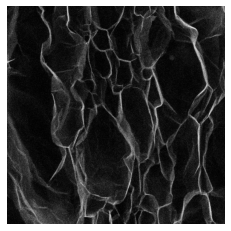

In [ ]:
plt.imshow(np.load(img_names[i]), cmap='gray')
plt.axis('off')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/img.jpg', dpi=300, bbox_inches='tight')

**Прорисовываются границы больших пор, но НЕ мелких!!! Нужно делать watershed как с большим параметром (отвечает за границы больших пор), так и с малым (отвечает за границы мелких пор)!!!**

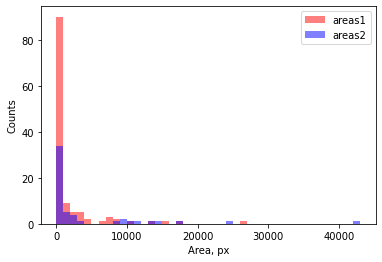

0.375

In [ ]:
#Compare histograms of ground-truth and predicted masks
hist_consistency.intersection(area_mask, area_pred, bin_width=1000, plot_hist=True)

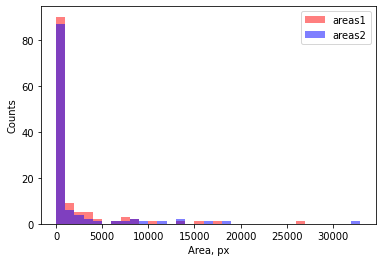

0.8203125

In [ ]:
#Compare histograms of ground-truth and postprocessed masks
hist_consistency.intersection(area_mask, area_pred_postproc, bin_width=1000, plot_hist=True)

In [20]:
thresholds = [i / 10. for i in range(10, -1, -1)]
consistencies = dict()

In [21]:
#Predict masks of 3000 raw images of size 512x512, postprocess them using watershed algorithm with fixed parameter
#Measure pore areas values of ground-truth and predicted masks
#Compare results by intersection values (Jaccard coefficient, or IoU value) of corresponding histograms
#Maximum average IoU value is optimum
N = 500
for threshold in thresholds:
        consistency = 0
        skip = 0
        for i in range(N):
            if i in [N // 3, (N // 3) * 2, N - 1]:
                print('#', end='')
            mask1 = np.load(mask_names[i])
            mask2 = np.load(predict_mask_names[i])
            #img = np.load(img_names[i])
            #img = np.expand_dims(img, axis=0).astype('float32')
            #img = torch.from_numpy(img).to(device).unsqueeze(0)
            #mask2 = model.predict(img)
            #mask2 = mask2.squeeze().cpu().detach().numpy().round().astype('uint8')
            mask2 = hist_consistency.postproc(mask2, sure_fg_threshold=threshold)
            area1 = hist_consistency.area(mask1)
            area2 = hist_consistency.area(mask2)
            area1 = area1[area1 > 25]
            area2 = area2[area2 > 25]
            if area1.shape[0] == 0 or area2.shape[0] == 0:
                skip += 1
                continue
            consistency += hist_consistency.intersection(area1, area2, bin_width=100, plot_hist=False)
        consistencies[(1, threshold)] = consistency / (N - skip)
        print(' ', (1, threshold), consistencies[(1, threshold)], skip)

###  (1, 1.0) 0.44298424811370357 27
###  (1, 0.9) 0.44504942891655447 28
###  (1, 0.8) 0.44556970483027225 28
###  (1, 0.7) 0.44733304611486996 28
###  (1, 0.6) 0.44942534520243416 28
###  (1, 0.5) 0.45412205029542274 28
###  (1, 0.4) 0.46481704548111524 28
###  (1, 0.3) 0.4743040046603071 27
###  (1, 0.2) 0.4887522477077775 27
###  (1, 0.1) 0.5118680620920754 27
###  (1, 0.0) 0.44298424811370357 27
